# VLB Creep Compliance: NLSQ → NUTS

**Polystyrene at 190 °C — creep compliance J(t)**

## Learning Objectives

- Fit creep compliance J(t) to extract G₀ and k_d
- Understand Maxwell creep: J(t) = (1/G₀)(1 + k_d·t)
- Compare NLSQ and NUTS posteriors for both parameters

## Data Source

Polystyrene creep at 190 °C from pyRheo demo datasets.

## Estimated Runtime

- Fast demo (1 chain): ~1 min
- Full run (4 chains): ~3 min

In [1]:
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax openpyxl
    import os
    os.environ["JAX_ENABLE_X64"] = "true"

In [2]:
%matplotlib inline
import time
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models import VLBLocal

jax, jnp = safe_import_jax()
verify_float64()
warnings.filterwarnings('ignore', category=FutureWarning)

# Tutorial utilities
import sys

sys.path.insert(0, str(Path('..').resolve()))
from utils.vlb_tutorial_utils import (
    get_bayesian_config,
    get_output_dir,
    load_ps_creep,
    plot_trace_and_forest,
    print_convergence,
    print_parameter_table,
    save_figure,
    save_results,
)

print(f"JAX version: {jax.__version__}")
import os
import sys

sys.path.insert(0, os.path.dirname(os.path.abspath("")))
from utils.plotting_utils import (
    display_arviz_diagnostics,
    plot_nlsq_fit,
    plot_posterior_predictive,
)

JAX version: 0.8.3


## 2. Load Experimental Data

Data points: 200
Time range: 0.20 - 3605 s
J range: 2.61e-05 - 5.37e-02 1/Pa


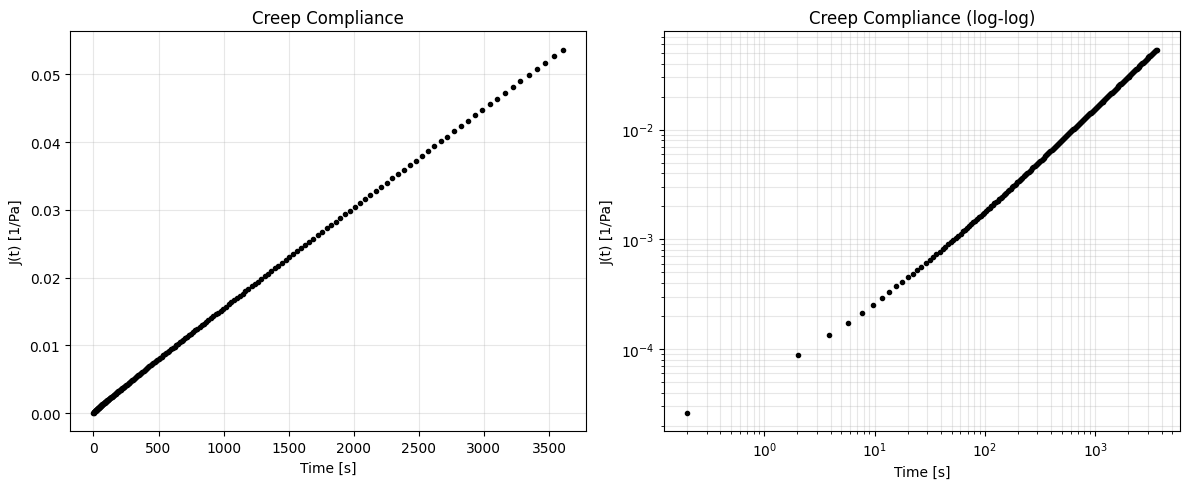

In [3]:
time_data, J_data = load_ps_creep(190, max_points=200)

print(f'Data points: {len(time_data)}')
print(f'Time range: {time_data.min():.2f} - {time_data.max():.0f} s')
print(f'J range: {J_data.min():.2e} - {J_data.max():.2e} 1/Pa')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(time_data, J_data, 'ko', markersize=3)
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('J(t) [1/Pa]')
ax1.set_title('Creep Compliance')
ax1.grid(True, alpha=0.3)

ax2.loglog(time_data, J_data, 'ko', markersize=3)
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('J(t) [1/Pa]')
ax2.set_title('Creep Compliance (log-log)')
ax2.grid(True, alpha=0.3, which='both')

plt.tight_layout()
display(fig)
plt.close(fig)

## 3. VLB Forward Model

For a Maxwell fluid under constant stress $\sigma_0$:

$$J(t) = \frac{1}{G_0}(1 + k_d \cdot t)$$

- **Short times:** elastic response $J(0) = 1/G_0$
- **Long times:** viscous flow $J \to k_d \cdot t / G_0 = t/\eta_0$
- Both $G_0$ and $k_d$ are individually identifiable from creep data

We set `sigma_applied=1.0` so the model returns $J(t)$ directly.

## 4. Step 1: NLSQ Point Estimation

INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=2 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.803891s


INFO:nlsq.least_squares:Convergence reason=`gtol` termination condition is satisfied. | iterations=16 | final_cost=0.7934 | elapsed=0.804s | final_gradient_norm=3.8644e-08


NLSQ fit time: 1.06 s
G0  = 2.95e+04 Pa
k_d = 4.7425e-01 1/s
eta_0 = 6.22e+04 Pa*s
R-squared = 0.991265


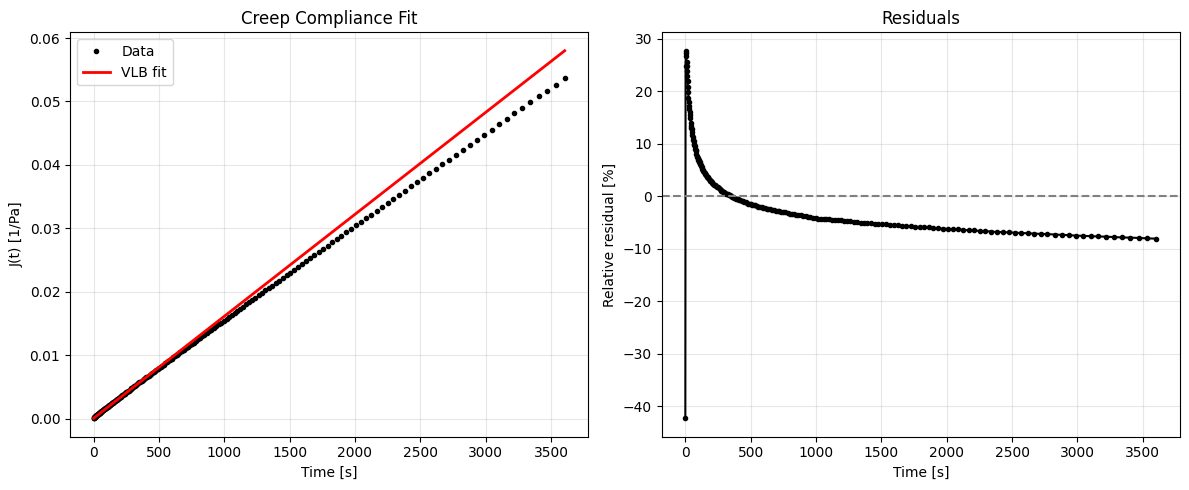

In [4]:
model = VLBLocal()

t0 = time.time()
model.fit(time_data, J_data, test_mode='creep', sigma_applied=1.0)
t_nlsq = time.time() - t0

print(f'NLSQ fit time: {t_nlsq:.2f} s')
print(f'G0  = {model.G0:.2e} Pa')
print(f'k_d = {model.k_d:.4e} 1/s')
print(f'eta_0 = {model.G0 / model.k_d:.2e} Pa*s')

# Fit quality
time_fine = np.linspace(time_data.min(), time_data.max(), 300)
J_pred_fine = model.predict(time_fine, test_mode='creep', sigma_applied=1.0)
J_pred = model.predict(time_data, test_mode='creep', sigma_applied=1.0)
ss_res = np.sum((J_data - np.array(J_pred))**2)
ss_tot = np.sum((J_data - np.mean(J_data))**2)
r2 = 1 - ss_res / ss_tot
print(f'R-squared = {r2:.6f}')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(time_data, J_data, 'ko', markersize=3, label='Data')
ax1.plot(time_fine, J_pred_fine, 'r-', lw=2, label='VLB fit')
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('J(t) [1/Pa]')
ax1.set_title('Creep Compliance Fit')
ax1.legend()
ax1.grid(True, alpha=0.3)

residuals = (J_data - np.array(J_pred)) / J_data * 100
ax2.plot(time_data, residuals, 'ko-', markersize=3)
ax2.axhline(0, color='gray', ls='--')
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('Relative residual [%]')
ax2.set_title('Residuals')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

## 4. Step 2: Bayesian Inference (NUTS)

In [5]:
config = get_bayesian_config()
initial_values = {'G0': float(model.G0), 'k_d': float(model.k_d)}
print(f'Config: {config}')
print(f'Warm-start: {initial_values}')

t0 = time.time()
result = model.fit_bayesian(
    time_data, J_data, test_mode='creep',
    sigma_applied=1.0,
    initial_values=initial_values,
    seed=42,
    **config,
)
t_bayes = time.time() - t0
print(f'\nBayesian inference time: {t_bayes:.1f} s')

Config: {'num_warmup': 50, 'num_samples': 100, 'num_chains': 1}
Warm-start: {'G0': 29490.72781694352, 'k_d': 0.47424900309807516}


  0%|          | 0/150 [00:00<?, ?it/s]

warmup:   1%|          | 1/150 [00:00<01:17,  1.92it/s, 1 steps of size 1.95e+00. acc. prob=0.00]

sample:  90%|█████████ | 135/150 [00:00<00:00, 290.15it/s, 191 steps of size 3.63e-03. acc. prob=0.94]

sample: 100%|██████████| 150/150 [00:00<00:00, 236.42it/s, 55 steps of size 3.63e-03. acc. prob=0.93] 


Bayesian inference time: 2.5 s


## 5. Convergence Diagnostics

In [6]:
param_names = ["G0", "k_d"]
converged = print_convergence(result, param_names)

Convergence Diagnostics
 Parameter     R-hat       ESS
--------------------------------------------------
        G0    1.8473         3 *
       k_d    1.8468         3 *

Divergences: 0
Convergence: CHECK REQUIRED


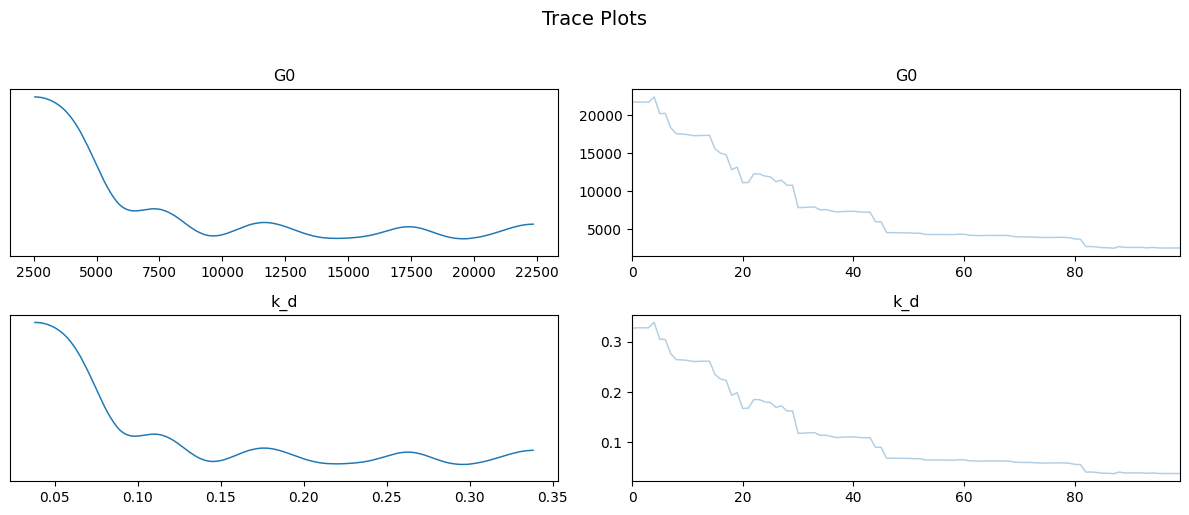

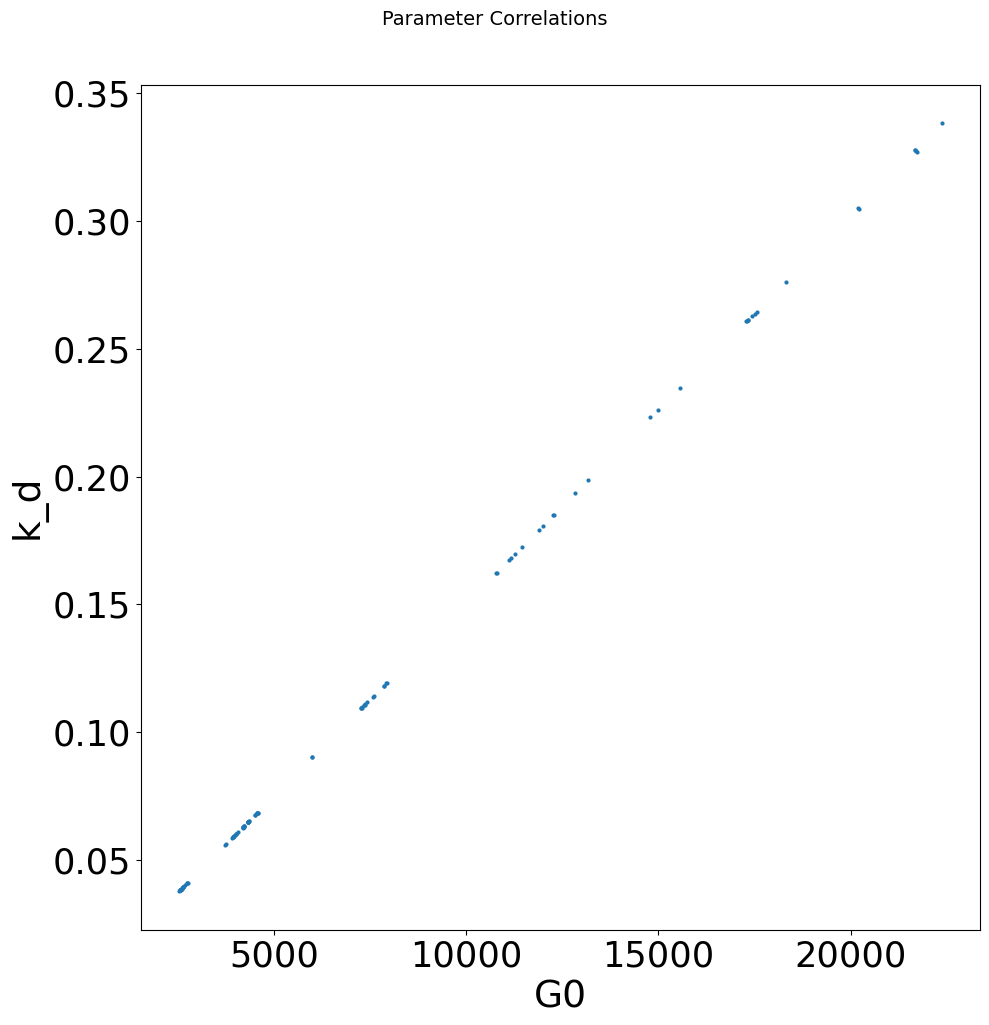

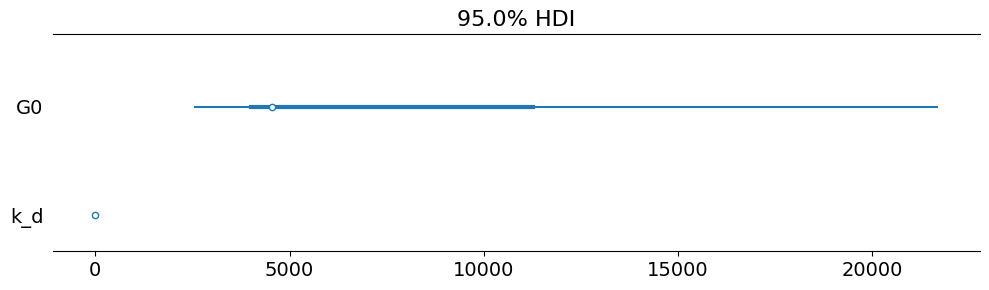

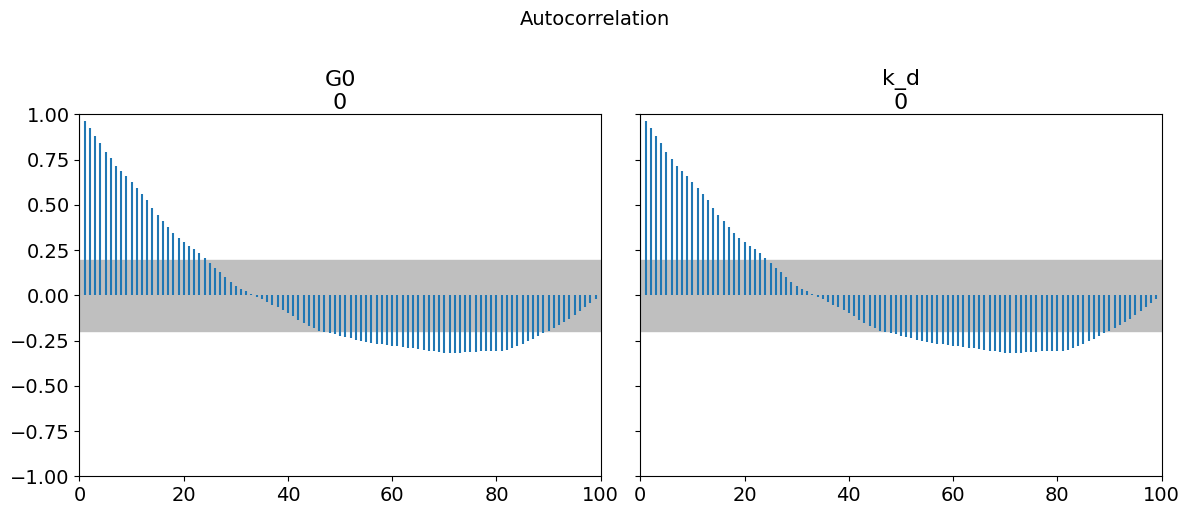

In [7]:
display_arviz_diagnostics(result, param_names, fast_mode=os.environ.get("FAST_MODE", "1") == "1")

## 6. Posterior Summary

In [8]:
posterior = result.posterior_samples
nlsq_vals = {"G0": model.G0, "k_d": model.k_d}
print_parameter_table(["G0", "k_d"], nlsq_vals, posterior)

Parameter Comparison
   Param        NLSQ  Bayes (median)                95% CI
----------------------------------------------------------
      G0   2.949e+04            4547  [2558, 2.169e+04]
     k_d      0.4742         0.06822  [0.03815, 0.3276]


## 7. Posterior Predictive Check

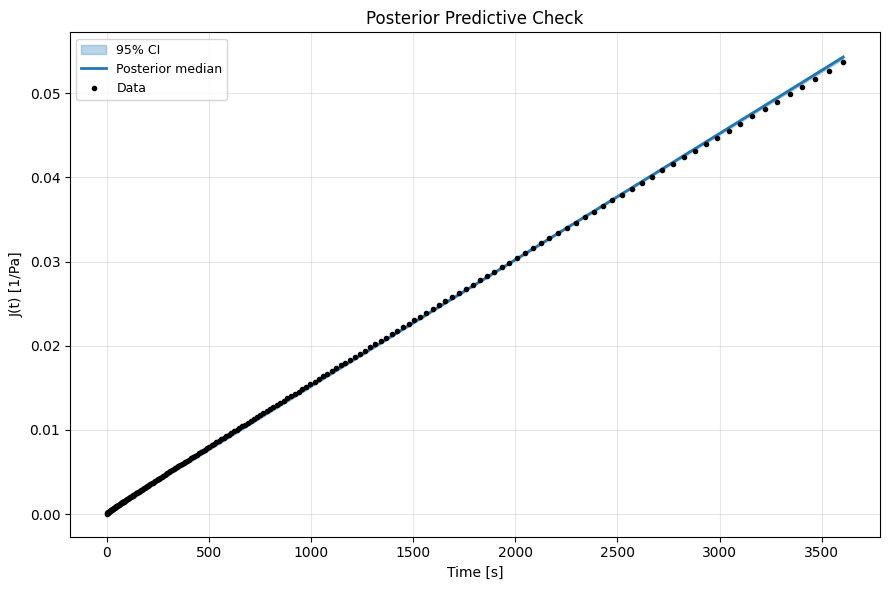

In [9]:
posterior = result.posterior_samples
n_draws = min(200, len(posterior['G0']))

J_samples = []
for i in range(n_draws):
    model.parameters.set_value('G0', float(posterior['G0'][i]))
    model.parameters.set_value('k_d', float(posterior['k_d'][i]))
    J_samples.append(np.array(
        model.predict(time_fine, test_mode='creep', sigma_applied=1.0)
    ))

J_arr = np.array(J_samples)

fig, ax = plt.subplots(figsize=(9, 6))
ax.fill_between(time_fine,
    np.percentile(J_arr, 2.5, axis=0),
    np.percentile(J_arr, 97.5, axis=0),
    alpha=0.3, color='C0', label='95% CI')
ax.plot(time_fine, np.median(J_arr, axis=0),
        'C0-', lw=2, label='Posterior median')
ax.plot(time_data, J_data, 'ko', markersize=3, label='Data')
ax.set_xlabel('Time [s]')
ax.set_ylabel('J(t) [1/Pa]')
ax.set_title('Posterior Predictive Check')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)
plt.tight_layout()
display(fig)
plt.close(fig)

## 8. Save Results

In [10]:
output_dir = get_output_dir("creep")
save_results(output_dir, model, result, ["G0", "k_d"], None)
print("Done.")

Saved to /Users/b80985/Projects/rheojax/examples/utils/../outputs/vlb/creep/
Done.


## Key Takeaways

1. **Creep compliance identifies both G₀ and k_d** independently
2. **Linear J(t) at long times** confirms Maxwell viscous flow
3. **Short-time intercept** gives 1/G₀ directly
4. **Long-time slope** gives k_d/G₀ = 1/η₀

## Next

- **Notebook 13**: Stress relaxation NLSQ → NUTS